# Sequences Time Series and Prediction

Time Series Examples
- Stock Prices
- Wheather Forecast

> *Definition*: Time Series 
> 
> It is an ordened sequence of values that are usually equally spaced over time (daily, monthly, quaterly, yearly, and so on)

The value of time series is when we find correlation between of them (no spurious relation). To find the relationship between time series those we can plot them
- $(t, x_{1t})$ and $(t, x_{2t})$
- $(x_{1t},  x_{2t})$

### *Tasks* using time series
- `Forecast` for next 10 periods
- Project back into the past or fill null values in a long time series (if no exists). This called `Data Inputation`)
- `Annomaly Detection`

### Common pattern in time series

- Trend (direction of time series)
- Seasonality (frequence in which happen specific spike or shrink)
- Combination of them
- White Noise (is not possible to predict)
- Autocorrelation (the current value is relationated to lag value)

20


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Train, Validation and Test Sets

To measure the performance of a model is usually split the data into (Fixed partition): 

If the data contains seasonly pattern, then the training, valitation and test data must contains whole seasonly pattern, montly, yearly, ... 

- Training set: using to train the model
- Validation set: used to measure the performance of the model in the training set and find the right architecture (hyperparameters)
- Test set: used to measure the performance of the model when forecast

For purpose of predict we often use all data, since test data and validation data is the closest data to current time, it contains current information.

- We can concat [Training set, Validation Set] and training the model using this set.
- The percent of each set is not defined, but, usually, (0.8, 0.1, 0.1)

Exists (Roll Forward Partition) in which instead of using all training set to train the model, we use 0.7 for the first training, using 0.7 + 1m (frequency of the time series) for second training and so on.

### Metrics

$$\text{error} = \hat{y} - y$$
- MSE `Mean Square Error` : $\text{avg}(\text{error}^{2})$
- RMSE `Root Mean Square Error` : $\sqrt{ \text{avg}(\text{error}^{2})}$
  - Return to original scale of the error 
- MAE `Mean Absolute Error` : $ \text{avg}(|\text{error}|)$
   - Not penalize large error like `MSE`
- MAPE `Mean Absolute Percent Error` : $ \text{avg}(|\frac{\text{error}}{y}|)$

> RMSE vs MAE
> 
> If aditional error (marginal error) involves more cost than earlier then we should use `RMSE`.
> But if the cost aditional error is equal to earlier we should use `MAE`

### Moving Average

Common Simple Forecasting Method: average of last 30 days (Windows) for example (if the frequency is daily). If we use this method on time serie it will drop the noise of the values but not anticipate tred or seasonality. 

To add this behaivor to prediction we can take the difference $d_{t}$ ($[y_{t}-y_{t-12}]$ or $[y_{t}-y_{t-6}]$, ...) of the time series in order eliminate the trend and seasonality.

We can compute the average of this difference $d_{t}$,  $  \hat{d}_{t+1}=\text{avg}(d_{t})$ for last 30 days and add $y_{t-11}$ to compute the forecast. 
$$\hat{y}_{t+1} = \hat{d}_{t+1} + y_{t-11}$$

But it contains noise, this come from $y_{t-11}$ so we can eliminate using moving average on $y_{t-11}$. 
$$\hat{y}_{t+1} = \hat{d}_{t+1} + \text{avg}(y_{t-11})$$


Trailling Moving Average on $x_t$ to predict $\hat{x}_{t+1}$ for a windows $w=10$:  

$$\hat{x_t} = \sum_{i=t-9}^{t} x_i$$

Centered Moving Average on $x_t$ to predict $\hat{x}_{t-5}$ for a windows $w=11$:  

$$\hat{x}_{t-5} = \sum_{i=t-10}^{t} x_i$$

Centered Moving Average is usually has better performance (less error) than Trailling Moving Average.

It can used when calculate the moving average on $y_{t-11}$ but not to calculate moving average on $d_t$.

On $d_t$ we should use Trailling Moving Average 

> *Spectral Representation*: says that any stationary process up to order two (covariance stationary or weakly stationary) can be represented by a possibly infinite sum of sinusoidal and cosine signals

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import torch
import torch.utils.data as data
import os
%matplotlib inline

In [5]:
uri = 'mysql://root:My:S3cr3t@127.0.0.1:30306/Programacion'
con = create_engine(uri)

In [19]:
data = pd.read_sql_query(
    """
    SELECT periodo, SUM(cant_matriculados) as total
    FROM ProgAcad WHERE sede <> "VECOR" AND estado <> "Cur. Cancelado" AND 
    (NOT REGEXP_LIKE(codigo_de_curso, ".+PV")) 
    GROUP BY periodo;""", con=con
    )

In [22]:
data.total

0     57040.0
1     60409.0
2     65231.0
3     61466.0
4     63111.0
5     62021.0
6     63238.0
7     61637.0
8     65488.0
9     59408.0
10    60460.0
11    50843.0
12    60702.0
13    60912.0
14    59440.0
15    56519.0
16    55052.0
17    52433.0
18    51941.0
19    52025.0
20    55163.0
21    49613.0
22    48744.0
23    41489.0
24    63573.0
25    60698.0
26    60847.0
27    55880.0
28    59133.0
29    56598.0
30    56008.0
31    54800.0
32    59356.0
33    52604.0
34    52836.0
35    45433.0
36    65318.0
37    61425.0
38    60644.0
39    57675.0
40    57241.0
41       56.0
Name: total, dtype: float64

In [ ]:
class TimeSeriesDataSet(data.Dataset):

    def __init__(self, tensor_dir, transform, window_size, stride):

        self.tensor_directory = tensor_dir
        self.transform = transform
        self.files = os.listdir(tensor_dir)
        self.window_size = window_size
        self.stride = stride
        self.data_tuples = []

        for f in self.files:
            file = os.path.join(tensor_dir, f)
            data, label = torch.load(file)

            # pad with zeros with tensor is not of right length
            if (data.size(0) % self.window_size) != 0:
                zeros = torch.zeros(abs(self.window_size - (data.size(0) % self.window_size)), data.size(1)).double()
                data = torch.cat((data, zeros), axis=0)

            idxs = [i for i in range(0, data.size(0) - self.window_size, self.stride)]

            if len(idxs) == 0:
                continue

            for j in idxs:
                data_tuple = (file, j, label)
                self.data_tuples.append(data_tuple)

        shuffle(self.data_tuples)

    def __len__(self):
        return len(self.data_tuples)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample_tuple = self.data_tuples[idx]
        sample, _ = torch.load(sample_tuple[0])
        label = sample_tuple[2]
        sample = sample[sample_tuple[1]: sample_tuple[1] + self.window_size]

        if self.transform:
            sample = self.transform(sample)

        return {'sample': sample, 'label': label}

In [16]:
(data.total)

0     57040.0
1     60409.0
2     65231.0
3     61466.0
4     63111.0
5     62021.0
6     63238.0
7     61637.0
8     65488.0
9     59408.0
10    60460.0
11    50843.0
12    60702.0
13    60912.0
14    59440.0
15    56519.0
16    55052.0
17    52433.0
18    51941.0
19    52025.0
20    55163.0
21    49613.0
22    48744.0
23    41489.0
24    63573.0
25    60698.0
26    60847.0
27    55880.0
28    59133.0
29    56598.0
30    56008.0
31    54800.0
32    59356.0
33    52604.0
34    52836.0
35    45433.0
36    65318.0
37    61425.0
38    60644.0
39    57675.0
40    57241.0
41       56.0
Name: total, dtype: float64

In [566]:
def spectral(t):
    # frequency
    freq = 1/12
    # amplitudes
    a, b = 0.08, 0.01
    # constant
    c = 10
    π = np.pi
    # linear combination 
    lc = sum([a * np.cos(2*π*freq*t) + b* np.sin(2*π*freq*t) for m in range(50)])
    # y = constant + trend + lc + error 
    return c + 0.3*t + lc + np.random.randn()

spectral = np.vectorize(spectral)
base = np.arange(150)
x = spectral(base)

In [710]:
index = pd.period_range(start='1/1/2018', freq='m', periods=150)
index = index.to_timestamp()
data = pd.DataFrame(x, index = index, columns=["Alumn"])

In [711]:
alumn = data.Alumn

In [712]:
alumn_diff = (alumn - alumn.shift(12))

In [718]:
alumn_diff_rolling = alumn_diff.rolling(4).mean()

In [719]:
idx_predict = alumn_diff_rolling.index + pd.DateOffset(months = 1)

In [720]:
rolling_predict = pd.Series(alumn_diff_rolling.values, index=idx_predict)

In [723]:
alumn_lag = pd.Series(alumn.shift(11).rolling(4).mean().values, index=idx_predict)

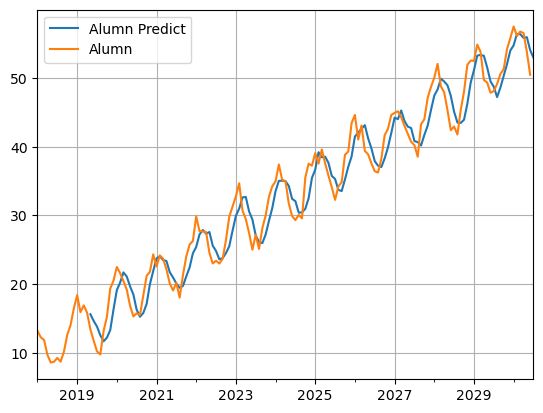

In [728]:
alumn_predict =  rolling_predict + alumn_lag
alumn_predict.name = 'Alumn Predict'
ax = alumn_predict.plot(legend=True)
alumn.plot(legend=True, ax = ax)
ax.grid()

In [725]:
# Mean Absolute Error
np.mean(np.abs((alumn_predict - alumn).dropna()))

2.1468927950205474

In [726]:
# Root Mean Squared Error
np.sqrt(np.mean(((alumn_predict - alumn).dropna())**2))

2.518868142719159

### Deep Neural Networks for Time Series

In [2]:
import torch

In [7]:
for x in torch.arange(0,10):
    print(x)

tensor(0)
tensor(1)
tensor(2)
tensor(3)
tensor(4)
tensor(5)
tensor(6)
tensor(7)
tensor(8)
tensor(9)


# Advanced Neural Network 

Neural network models for financial time series analysis  

Recurrent neural networks (RNNs) are presented as *nonlinear time series models* and generalize classical linear time series models such as $\text{AR({p})}$.

Convultion neural network for `filtering` time series data and exploiting different scales in the data

Autoencoders for `compress information` and generalize principal component analysis.

Others architectures exists since those can be fit to the structure so good to data, that is, some architectures are designed to be used on some type of structure of data and those have been proven to be more efficient to others architectures (those don't need to be training again on some parameters needlessly)

## Recurrent Neural Networks

RNNs or Recurrent Neural Networks are a family of neural networks that are used for (specialized for) *processing sequences of data* e.g. $[x^{<1>}, x^{<2>}, ..., x^{<N}]$. This specialization allows it scale to *processing large sequences of data*.

If the data $D= \{ x_t, y_t \}^{N}_{t=1}$ is autocorrelated observations of $X$ and $Y$ at times $t = 1, ..., N$, then the problem can be expresed as secuential problem.

Given the response $y_{t + h}$ the model can be expressed as:

$$\hat{y}_{t + h} = f(\textbf{X}_{t}) $$

Where $\textbf{X}_{t} = \text{Seq}_{T}(X) = (x_{t-(T-1)}, ..., x_{t})$. Here $T$ point out the length of sequence (or the *window*) of $x$, so if $T = 3$, the sequence have at max $2=T-1$ lags.

If the data are not *autocorrelationated* the model to use would be Feedforward Neural Network.

There are many types of *RNN*, but the simplest is *Elman Network*. A RNN with one hidden layer, and the length of sequence of $x$ is $T$ so the max lag would  be $T-1$. 

*Hidden state*: $z_{t-j} = f^{(1)}_{W^{(1)}, b^{(1)}} (\textbf{X}_{t, j}) := \sigma^{(1)}{( W^{(1)}_z z_{(t-j)-1} + W^{(1)}_x x_{t-j} + b^{(1)})}$

*Response*: $\hat{y}_{t+h} = f^{(2)}_{W^{(2)}, b^{(2)}} (z_t)  =\sigma^{(2)} {(W^{(2)}z_t + b^{(2)})}$

Where $\sigma^{(1)}$ is a activation function such as *tanh* and $\sigma^{(2)}$ is a output function, this can be softmax function or any other, this depend if the response is *categorical* or *continuous*

The connections between input $x_t$ and the $H$ hidden units are weighted by the time invariant matrix  $W^{(1)}_{x} \in \mathbb{R}^{H\text{x}P}$ ($P$ is the dimention of $x_t$).

The recurrent connections between the $H$ hidden units are weighted by the time invariant matrix $W_z^{(1)} \in \mathbb{R}^{H\text{x}H}$. 

The sets $W^{(1)} = (W^{(1)}_{x}, W^{(1)}_{z}) $ refer to input and recurrence weights.  $W^{(2)}$ denotes the weights tied to output of the hidden layer of the last time step, $z_t$ and the output layer. If the response is a continuous vector, $Y \in R^{M}$, then the $W^{(2)} \in R^{M\text{x}H}$. If the response is categorical with $K$ classes, then $W^{(2)} \in R^{K\text{x}H} $ 

Problems with RNN

- Vanish/exploted gradient problem. Vanish if weights is close to 0 and explote if the weights is greater than 1


## Long Short-Term Memory (LSTM)

The cell memory is updated 

The update of cell memory depend on *forget gate* $\hat{\alpha_t}$, *input gate* $\hat{z_{t}}$ and cell gate $\hat{c_t}$

$$c_t = \hat{\alpha}\: \text{o} \:c_{t-1} + \hat{z}_t \: \text{o} \: \hat{c}_{t}  $$

Where $\hat{\alpha_t}$ is refered as *forget gate*, $\hat{z_{t}}$ as *input gate* and $\hat{r}$ as *output gate*

The hidden state is updated using the followig definition:

$$h_t = \hat{r_t} \: \text{o} \: \tanh{(c_t)}$$

The  reset, forget, input and cell memory gates ared updated by *RNN* and all depending on the hidden state $h_t$

$$ \text{Output gate} :  \hat{r_{t}} = \sigma(U_r h_{t-1} + W_r x_t + b_r)$$
$$ \text{Forget gate} : \hat{\alpha_{t}} = \sigma(U_{\alpha} h_{t-1} + W_{\alpha} x_t + b_{\alpha})$$
$$ \text{Input gate} : \hat{z_{t}} = \sigma(U_{z} h_{t-1} + W_z x_t + b_z)$$
$$ \text{Cell memory gate} : \hat{c_{t}} = \sigma(U_{c} h_{t-1} + W_c x_t + b_c)$$

In [1]:
import numpy as np
import torch
import pandas as pd

In [21]:
np.random.seed(2)

T = 20
L = 1000
N = 100

x = np.empty((N, L), 'int64')

# [0, 1, ..., 1000]x[[0.2], ..., [-0.83]]
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)

data = np.sin(x / 1.0 / T).astype('float64')
# torch.save(data, open('traindata.pt', 'wb'))

In [1]:
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchviz

In [1]:
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(1, 51)
        self.lstm2 = nn.LSTMCell(51, 51)
        self.linear = nn.Linear(51, 1)

    def forward(self, input, future = 0):
        outputs = []
        h_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        h_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)

        for input_t in input.split(1, dim=1):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
            
        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        outputs = torch.cat(outputs, dim=1)
        return outputs

In [17]:
# set random seed to 0
opt_steps = 10
np.random.seed(0)
torch.manual_seed(0)
# load data and make training set
data = torch.load('traindata.pt')
input = torch.from_numpy(data[3:, :-1])
target = torch.from_numpy(data[3:, 1:])
test_input = torch.from_numpy(data[:3, :-1])
test_target = torch.from_numpy(data[:3, 1:])

In [24]:
input.shape

torch.Size([97, 999])

In [ ]:
# build the model
seq = Sequence()
seq.double()
criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.LBFGS(seq.parameters(), lr=0.8)
#begin to train
for i in range(opt_steps):
    print('STEP: ', i)
    def closure():
        optimizer.zero_grad()
        out = seq(input)
        loss = criterion(out, target)
        print('loss:', loss.item())
        loss.backward()
        return loss
    optimizer.step(closure)
    # begin to predict, no need to track gradient here
    with torch.no_grad():
        future = 1000
        pred = seq(test_input, future=future)
        loss = criterion(pred[:, :-future], test_target)
        print('test loss:', loss.item())
        y = pred.detach().numpy()
    # draw the result
    plt.figure(figsize=(30,10))
    plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    def draw(yi, color):
        plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
        plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
    draw(y[0], 'r')
    draw(y[1], 'g')
    draw(y[2], 'b')
    plt.savefig('predict%d.pdf'%i)
    plt.close()

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Hyperparameters
learning_rate = 0.001
epochs = 100
sequence_length = 50  # Number of past time steps to consider for prediction

# Sample data (replace with your actual data)
data = torch.arange(100).float()

# Create sequences for training
def create_sequences(data, seq_length):
  sequences = []
  for i in range(len(data) - seq_length):
    sequence = data[i:i+seq_length]
    sequences.append(sequence)
  return torch.stack(sequences)

train_sequences = create_sequences(data[:-1], sequence_length)
target_values = data[sequence_length:]

# Define the LSTM model
class LSTMModel(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    super(LSTMModel, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
    self.linear = nn.Linear(hidden_size, 1)

  def forward(self, x):
    x, _ = self.lstm(x)  # Discard hidden and cell states for simplicity
    out = self.linear(x[:, -1, :])  # Use only the last output of the sequence
    return out

# Create model, optimizer, and loss function
model = LSTMModel(1, 64, 1)  # Input size, hidden size, number of layers
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Create datasets and dataloaders
train_dataset = TensorDataset(train_sequences, target_values)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Training loop
for epoch in range(epochs):
  for i, (sequences, labels) in enumerate(train_loader):
    # Forward pass
    outputs = model(sequences)
    loss = criterion(outputs, labels)

    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 100 == 0:
      print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

# Prediction function (modify based on your needs)
def predict(model, data, sequence_length):
  with torch.no_grad():
    last_sequence = data[-sequence_length:]
    prediction = model(last_sequence.unsqueeze(0))
  return prediction.item()

# Example prediction
predicted_value = predict(model, data, sequence_length)
print(f'Predicted value for next time step: {predicted_value}')
